In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [2]:
file_path = "ibm.csv"
file_cleaned_path = "cleaned_ibm_data.csv"
data = pd.read_csv(file_path)

print(data.head())

                        Date      Open      High       Low     Close  Volume  \
0  1962-01-02 00:00:00-05:00  1.518550  1.518550  1.501487  1.501487  407940   
1  1962-01-03 00:00:00-05:00  1.501487  1.514612  1.501487  1.514612  305955   
2  1962-01-04 00:00:00-05:00  1.514613  1.514613  1.498863  1.499519  274575   
3  1962-01-05 00:00:00-05:00  1.497551  1.497551  1.467363  1.469988  384405   
4  1962-01-08 00:00:00-05:00  1.468675  1.468675  1.430613  1.442425  572685   

   Dividends  Stock Splits  
0        0.0           0.0  
1        0.0           0.0  
2        0.0           0.0  
3        0.0           0.0  
4        0.0           0.0  


In [3]:
data_filtered = data[["Date", "Open", "High", "Low", "Volume", "Close"]].sort_values(by="Date")
data_cleaned = data_filtered.dropna()
print(data_filtered.head())

                        Date      Open      High       Low  Volume     Close
0  1962-01-02 00:00:00-05:00  1.518550  1.518550  1.501487  407940  1.501487
1  1962-01-03 00:00:00-05:00  1.501487  1.514612  1.501487  305955  1.514612
2  1962-01-04 00:00:00-05:00  1.514613  1.514613  1.498863  274575  1.499519
3  1962-01-05 00:00:00-05:00  1.497551  1.497551  1.467363  384405  1.469988
4  1962-01-08 00:00:00-05:00  1.468675  1.468675  1.430613  572685  1.442425


In [4]:
data_cleaned.to_csv(file_cleaned_path, index=False)

In [5]:
data = pd.read_csv(file_cleaned_path)
data.head()

,Date,Open,High,Low,Volume,Close
0,1962-01-02 00:00:00-05:00,1.518550,1.518550,1.501487,407940,1.501487
1,1962-01-03 00:00:00-05:00,1.501487,1.514612,1.501487,305955,1.514612
2,1962-01-04 00:00:00-05:00,1.514613,1.514613,1.498863,274575,1.499519
3,1962-01-05 00:00:00-05:00,1.497551,1.497551,1.467363,384405,1.469988
4,1962-01-08 00:00:00-05:00,1.468675,1.468675,1.430613,572685,1.442425


In [6]:
data["Target"] = data["Close"].shift(-1)
data.head()

,Date,Open,High,Low,Volume,Close,Target
0,1962-01-02 00:00:00-05:00,1.518550,1.518550,1.501487,407940,1.501487,1.514612
1,1962-01-03 00:00:00-05:00,1.501487,1.514612,1.501487,305955,1.514612,1.499519
2,1962-01-04 00:00:00-05:00,1.514613,1.514613,1.498863,274575,1.499519,1.469988
3,1962-01-05 00:00:00-05:00,1.497551,1.497551,1.467363,384405,1.469988,1.442425
4,1962-01-08 00:00:00-05:00,1.468675,1.468675,1.430613,572685,1.442425,1.459488


In [7]:
final_data_row = data.tail(1)
data.drop(data.tail(1).index, inplace=True)
data.dropna(inplace=True)
final_data_row

,Date,Open,High,Low,Volume,Close,Target
15825,2024-11-13 00:00:00-05:00,209.5,211.410004,209.070099,2186158,210.669998,NaN


In [9]:
# plotting correlation
data.iloc[:, 1:].corr()['Close']

,Close
Open,0.999893
High,0.999946
Low,0.999946
Volume,0.133603
Close,1.000000
Target,0.999812


In [10]:
# Features scaling
model_features = data.drop("Target", axis=1).drop("Date", axis=1)
model_target = data["Target"]

model_feature_scaler = MinMaxScaler()
model_feature_scaler.fit(model_features)
model_scaled_features = pd.DataFrame(model_feature_scaler.transform(model_features), columns=model_features.columns.tolist())

model_target_scaler = MinMaxScaler()
model_target_scaler.fit(model_target.values.reshape(-1,1))
model_scaled_target = pd.DataFrame(model_target_scaler.transform(model_target.values.reshape(-1,1)), columns=["Target"])

In [11]:
def create_dataset(X_data, y_data, t_steps):
    X, y = [], []
    for i in range(len(X_data) - t_steps):
        v = X_data.iloc[i:(i + t_steps)].values
        X.append(v)
        y.append(y_data.iloc[i + t_steps])
    return np.array(X), np.array(y)

In [12]:
t_steps = 60
X, y = create_dataset(model_scaled_features, model_scaled_target, t_steps)
X.shape, y.shape

((15765, 60, 5), (15765, 1))

In [13]:
train_size = int(0.80 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((12612, 60, 5), (3153, 60, 5), (12612, 1), (3153, 1))

In [14]:
X_train.shape

(12612, 60, 5)

In [15]:
import tensorflow as tf

X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
y_train = tf.convert_to_tensor(y_train, dtype=tf.float32)
X_test = tf.convert_to_tensor(X_test, dtype=tf.float32)
y_test = tf.convert_to_tensor(y_test, dtype=tf.float32)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

(TensorShape([12612, 60, 5]),
 TensorShape([12612, 1]),
 TensorShape([3153, 60, 5]),
 TensorShape([3153, 1]))

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [17]:
input_shape = (X_train.shape[1], X_train.shape[2])  # (time_step, features)
input_shape

(60, 5)

In [25]:
# X_train.shape[1]

60

### LSTM Model

In [18]:
model = Sequential([
    LSTM(units=50, return_sequences=True, input_shape=input_shape),
    LSTM(units=50),
    Dense(units=1)
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [19]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [20]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 60, 50)              │          11,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,451 (122.86 KB)

 Trainable params: 31,451 (122.86 KB)

 Non-trainable params: 0 (0.00 B)

In [21]:
# Training the model
num_epochs = 30
batch_size = 64

history_lstm = model.fit(X_train, y_train, epochs=num_epochs, batch_size=batch_size, validation_data=(X_test, y_test))

Epoch 1/30
198/198 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.0018 - val_loss: 4.5133e-04
Epoch 2/30
198/198 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 3.3578e-05 - val_loss: 5.4822e-04
Epoch 3/30
198/198 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 3.9598e-05 - val_loss: 3.8185e-04
Epoch 4/30
198/198 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 3.1993e-05 - val_loss: 2.9863e-04
Epoch 5/30
198/198 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 2.8376e-05 - val_loss: 3.5685e-04
Epoch 6/30
198/198 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 3.3166e-05 - val_loss: 3.4843e-04
Epoch 7/30
198/198 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 3.0950e-05 - val_loss: 9.4540e-04
Epoch 8/30
198/198 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 3.4024e-05 - val_loss: 2.5289e-04
Epoch 9/30
198/198 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 2.6365e-05 - val_loss: 2.6164e-04
Epoch 10/30
198/198 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 2.5319e-05 - val_loss: 2.2758e-04
Epoch 11/30
198/198 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss

In [22]:
# Evaluate on test data
test_loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}')

99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 9.0051e-05
Test Loss: 0.00014268681115936488


### Calculating the metrices

In [23]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

def calculate_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    return mse, rmse, mae


In [25]:
# Making predictions on the test set
# lstm_predictions = model.predict(X_test)
from sklearn.preprocessing import MinMaxScaler


predictions = model.predict(X_test)

# Adding dummy columns to match the original scaled data shape (5 columns)
# 4 dummy columns to match Open, High, Low, Volume
dummy_columns = np.zeros((predictions.shape[0], 4))
predicted_prices_scaled = np.concatenate((dummy_columns, predictions), axis=1)

# Applying inverse transformation to get back to original scale
predicted_prices = model_feature_scaler.inverse_transform(predicted_prices_scaled)[:, -1]

# for actual prices
actual_prices_scaled = np.concatenate((dummy_columns, y_test.numpy().reshape(-1, 1)), axis=1)
actual_prices = model_feature_scaler.inverse_transform(actual_prices_scaled)[:, -1]

# Calculating metrics
lstm_mse, lstm_rmse, lstm_mae = calculate_metrics(actual_prices, predicted_prices)
print(f'LSTM Model - MSE: {lstm_mse:.4f}, RMSE: {lstm_rmse:.4f}, MAE: {lstm_mae:.4f}')


99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
LSTM Model - MSE: 7.7209, RMSE: 2.7786, MAE: 2.0169


### RNN model

In [29]:
rnn_model = Sequential([
    tf.keras.layers.SimpleRNN(units=50, return_sequences=True, input_shape=input_shape),
    tf.keras.layers.SimpleRNN(units=50),
    Dense(units=1)
])

rnn_model.compile(optimizer='adam', loss='mean_squared_error')

history_rnn = rnn_model.fit(X_train, y_train, epochs=num_epochs, batch_size=batch_size, validation_data=(X_test, y_test))

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


198/198 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - loss: 0.0018 - val_loss: 9.1256e-04
Epoch 2/30
198/198 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - loss: 1.3175e-04 - val_loss: 6.5370e-04
Epoch 3/30
198/198 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 8.3369e-05 - val_loss: 6.8502e-04
Epoch 4/30
198/198 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 8.0727e-05 - val_loss: 6.2820e-04
Epoch 5/30
198/198 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 6.5607e-05 - val_loss: 6.0617e-04
Epoch 6/30
198/198 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 4.9629e-05 - val_loss: 0.0013
Epoch 7/30
198/198 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 5.3482e-05 - val_loss: 6.8450e-04
Epoch 8/30
198/198 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 8.8188e-05 - val_loss: 5.2321e-04
Epoch 9/30
198/198 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - loss: 4.1771e-05 - val_loss: 4.6284e-04
Epoch 10/30
198/198 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 3.6825e-05 - val_loss: 3.7580e-04
Epoch 11/30
198/198 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 7.1280

In [30]:
# Make predictions and evaluate RNN model
rnn_predictions = rnn_model.predict(X_test)


# Add dummy columns to match the original scaled data shape (5 columns)
dummy_columns = np.zeros((rnn_predictions.shape[0], 4))  # 4 dummy columns to match Open, High, Low, Volume
predicted_prices_scaled = np.concatenate((dummy_columns, rnn_predictions), axis=1)

# Apply inverse transformation to get back to original scale
predicted_prices = model_feature_scaler.inverse_transform(predicted_prices_scaled)[:, -1]  # Get only the Close column

# Similarly for actual prices
actual_prices_scaled = np.concatenate((dummy_columns, y_test.numpy().reshape(-1, 1)), axis=1)
actual_prices = model_feature_scaler.inverse_transform(actual_prices_scaled)[:, -1]


rnn_mse, rnn_rmse, rnn_mae = calculate_metrics(actual_prices, predicted_prices)
print(f'RNN Model - MSE: {rnn_mse:.4f}, RMSE: {rnn_rmse:.4f}, MAE: {rnn_mae:.4f}')

99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step
RNN Model - MSE: 10.6426, RMSE: 3.2623, MAE: 2.5252


### GRU model

In [31]:
# GRU model
gru_model = Sequential([
    tf.keras.layers.GRU(units=50, return_sequences=True, input_shape=input_shape),
    tf.keras.layers.GRU(units=50),
    Dense(units=1)
])

# Compile the GRU model
gru_model.compile(optimizer='adam', loss='mean_squared_error')

# Train the GRU model
history_gru = gru_model.fit(X_train, y_train, epochs=num_epochs, batch_size=batch_size, validation_data=(X_test, y_test))

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


198/198 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0010 - val_loss: 2.1359e-04
Epoch 2/30
198/198 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 1.7727e-05 - val_loss: 2.7514e-04
Epoch 3/30
198/198 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 2.7783e-05 - val_loss: 3.2400e-04
Epoch 4/30
198/198 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 1.6552e-05 - val_loss: 1.4887e-04
Epoch 5/30
198/198 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 1.7633e-05 - val_loss: 1.5757e-04
Epoch 6/30
198/198 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 1.5752e-05 - val_loss: 2.0463e-04
Epoch 7/30
198/198 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 1.5578e-05 - val_loss: 1.3932e-04
Epoch 8/30
198/198 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 1.5481e-05 - val_loss: 1.5405e-04
Epoch 9/30
198/198 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 1.5919e-05 - val_loss: 1.2161e-04
Epoch 10/30
198/198 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 1.4747e-05 - val_loss: 1.2284e-04
Epoch 11/30
198/198 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 1.5240e-

In [33]:
# Make predictions and evaluate GRU model
gru_predictions = gru_model.predict(X_test)

# Add dummy columns to match the original scaled data shape (5 columns)
dummy_columns = np.zeros((gru_predictions.shape[0], 4))  # 4 dummy columns to match Open, High, Low, Volume
predicted_prices_scaled = np.concatenate((dummy_columns, gru_predictions), axis=1)

# Apply inverse transformation to get back to original scale
predicted_prices = model_feature_scaler.inverse_transform(predicted_prices_scaled)[:, -1]  # Get only the Close column

# Similarly for actual prices
actual_prices_scaled = np.concatenate((dummy_columns, y_test.numpy().reshape(-1, 1)), axis=1)
actual_prices = model_feature_scaler.inverse_transform(actual_prices_scaled)[:, -1]

gru_mse, gru_rmse, gru_mae = calculate_metrics(actual_prices, predicted_prices)
print(f'GRU Model - MSE: {gru_mse:.4f}, RMSE: {gru_rmse:.4f}, MAE: {gru_mae:.4f}')

99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
GRU Model - MSE: 6.0086, RMSE: 2.4512, MAE: 1.6676


In [34]:
# import matplotlib.pyplot as plt

# plt.plot(history_gru.history['loss'], label='Training Loss')
# plt.plot(history_gru.history['val_loss'], label='Validation Loss')
# plt.title(' GRU Training vs. Validation Loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()

### Plotting training and validation accuracy and loss plot for each models

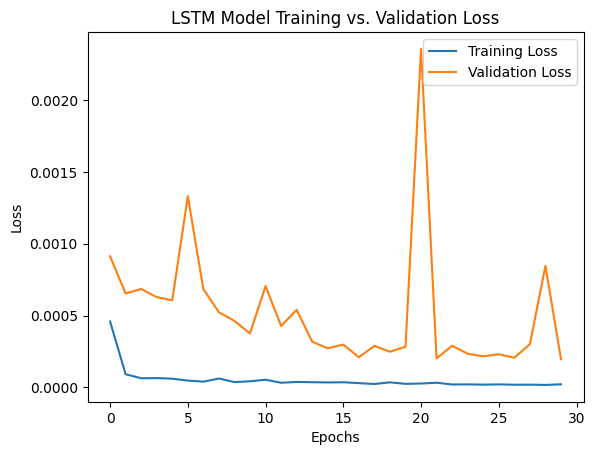

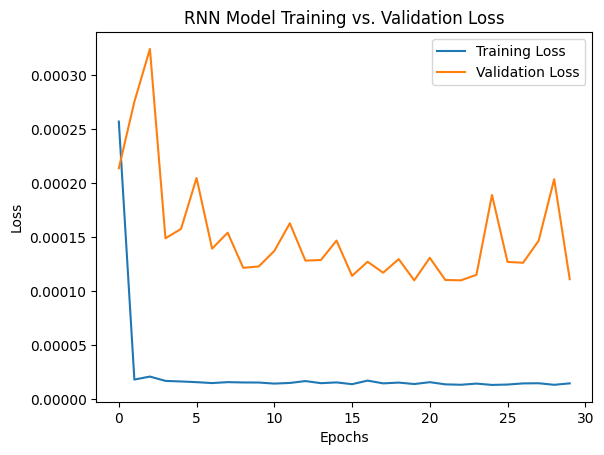

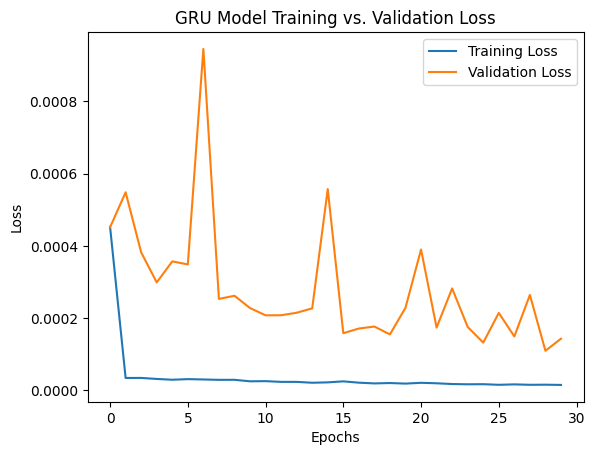

In [35]:
import matplotlib.pyplot as plt
# Plotting function for loss
def plot_loss(history, model_name):
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} Training vs. Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Plot loss for each model
plot_loss(history_rnn, 'LSTM Model')
plot_loss(history_gru, 'RNN Model')
plot_loss(history_lstm, 'GRU Model')

### Now hyperparameters tuning

Tuning hyperparameter and seeing the acc and loss plot differences

LSTM model hyperparameter tuning


In [36]:
def create_lstm_model(input_shape, lr=0.005):
  model = Sequential()
  model.add(LSTM(units=64, activation="tanh", return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
  model.add(BatchNormalization())
  model.add(LSTM(units=32, activation="tanh", return_sequences=False))
  model.add(BatchNormalization())
  model.add(Dropout(0.1))
  model.add(Dense(units=1))
  model.compile(optimizer=Adam(learning_rate=lr), loss='mean_squared_error', metrics=["mean_absolute_error", "r2_score"])
  return model

lstm_model = create_lstm_model(X_train.shape)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [37]:
lstm_history = lstm_model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    epochs=15,
    batch_size=32,
    shuffle=False,
    # callbacks=callbacks,
    verbose=1)

Epoch 1/15
395/395 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - loss: 0.1521 - mean_absolute_error: 0.0997 - r2_score: -184697.0469 - val_loss: 0.2605 - val_mean_absolute_error: 0.5031 - val_r2_score: -23.9500
Epoch 2/15
395/395 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - loss: 0.0182 - mean_absolute_error: 0.0662 - r2_score: -24839.8418 - val_loss: 0.0987 - val_mean_absolute_error: 0.3126 - val_r2_score: -8.4542
Epoch 3/15
395/395 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0180 - mean_absolute_error: 0.0660 - r2_score: -24127.8926 - val_loss: 0.2012 - val_mean_absolute_error: 0.4472 - val_r2_score: -18.2654
Epoch 4/15
395/395 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.0196 - mean_absolute_error: 0.0680 - r2_score: -26588.2852 - val_loss: 0.2801 - val_mean_absolute_error: 0.5235 - val_r2_score: -25.8229
Epoch 5/15
395/395 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - loss: 0.0193 - mean_absolute_error: 0.0670 - r2_score: -26359.4883 - val_loss: 0.1908 - val_mean_absolute_error: 0.4358 - val_r2_score: -17.269

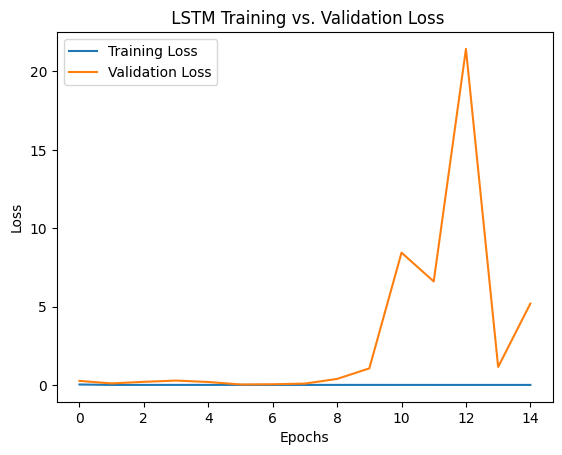

In [39]:
plt.plot(lstm_history.history['loss'], label='Training Loss')
plt.plot(lstm_history.history['val_loss'], label='Validation Loss')
plt.title(' LSTM Training vs. Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [40]:
# Making predictions on the test set
# lstm_predictions = model.predict(X_test)
from sklearn.preprocessing import MinMaxScaler


predictions = lstm_model.predict(X_test)

# Adding dummy columns to match the original scaled data shape (5 columns)
# 4 dummy columns to match Open, High, Low, Volume
dummy_columns = np.zeros((predictions.shape[0], 4))
predicted_prices_scaled = np.concatenate((dummy_columns, predictions), axis=1)

# Applying inverse transformation to get back to original scale
predicted_prices = model_feature_scaler.inverse_transform(predicted_prices_scaled)[:, -1]

# for actual prices
actual_prices_scaled = np.concatenate((dummy_columns, y_test.numpy().reshape(-1, 1)), axis=1)
actual_prices = model_feature_scaler.inverse_transform(actual_prices_scaled)[:, -1]

# Calculating metrics
lstm_mse, lstm_rmse, lstm_mae = calculate_metrics(actual_prices, predicted_prices)
print(f'New LSTM Model - MSE: {lstm_mse:.4f}, RMSE: {lstm_rmse:.4f}, MAE: {lstm_mae:.4f}')


99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
New LSTM Model - MSE: 280922.7482, RMSE: 530.0215, MAE: 234.7550


#### Very bad result , i think the model is too complex for our problem